In [16]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from misc.viz import plot2d
from model.setup import find_id_for_P, load_P_pred
from model.networks.linear import CalculatedP
from misc.viz import plot2d
from data.generate_2d import sine1d, sine2d, flower, mnist
from data.generate_data import datasets
from data.dataset import FlatDataset

from misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net, stringify_dict
from misc.wandb import exceptions, new_runs, update_results_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# update_results_df()

df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(525, 41)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'out_features'],
      dtype='object')


,lr,net,bias,name,seed,tags,test,n_val,train,y_low,...,num_workers,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,out_features
0,0.001,TrainP,False,None,2,"[mnist, new]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,red-dumpling-886,0.006070,NaN
1,0.010,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,beaming-firecracker-878,0.003705,NaN
2,0.100,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,lunar-envelope-879,0.003931,NaN
3,0.100,TrainP,False,None,2,"[mnist, new]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,dancing-bao-873,0.004032,NaN
4,0.001,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,glittering-noodles-872,0.005908,NaN


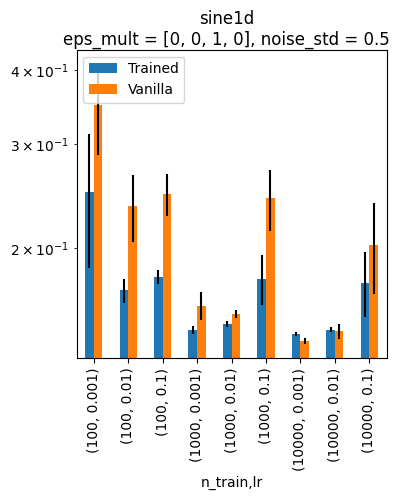

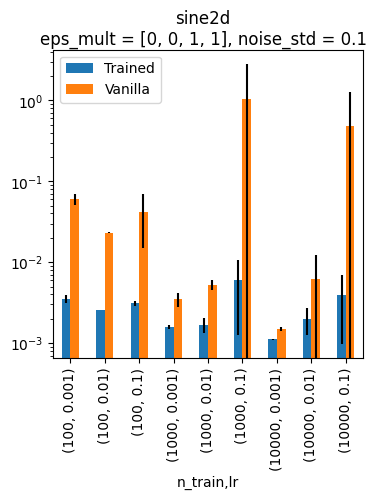

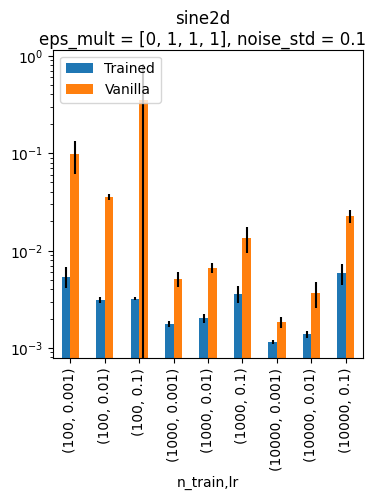

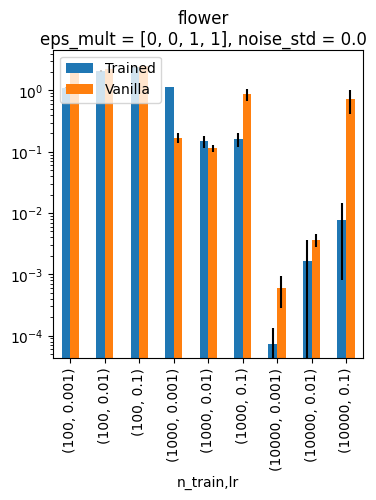

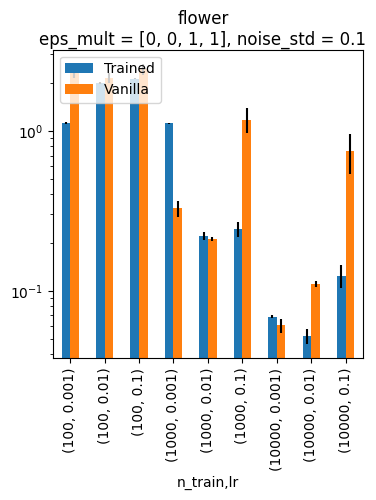

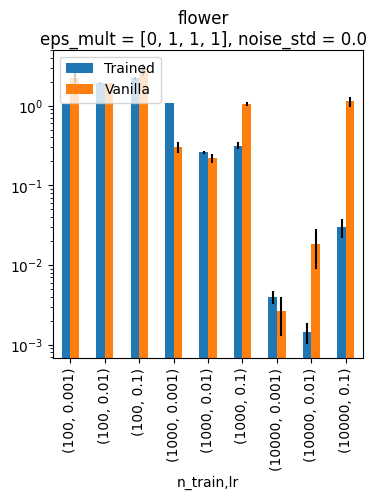

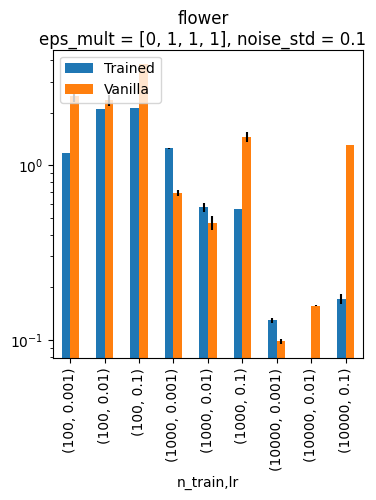

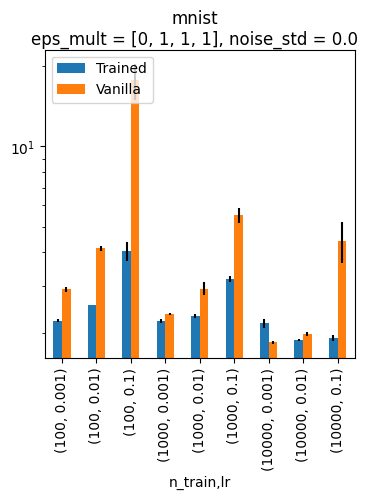

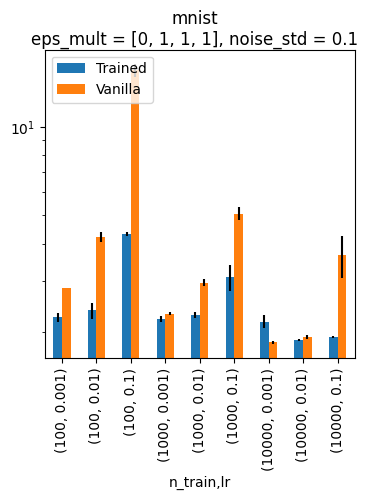

test_loss                       \
n_train                                              100                        
lr                                                 0.001                        
net                                              Trained              Vanilla   
dataset_name eps_mult     noise_std                                             
sine1d       [0, 0, 1, 0] 0.5        2.48e-01 ± 6.36e-02  3.49e-01 ± 6.15e-02   
sine2d       [0, 0, 1, 1] 0.1        3.49e-03 ± 4.08e-04  6.00e-02 ± 8.89e-03   
             [0, 1, 1, 1] 0.1        5.42e-03 ± 1.33e-03  9.78e-02 ± 3.62e-02   
flower       [0, 0, 1, 1] 0.0        1.11e+00 ± 1.26e-02  2.38e+00 ± 3.62e-01   
                          0.1        1.12e+00 ± 9.68e-03  2.31e+00 ± 1.88e-01   
             [0, 1, 1, 1] 0.0        1.04e+00 ± 7.26e-03  2.24e+00 ± 3.34e-01   
                          0.1             1.17e+00 ± nan  2.48e+00 ± 1.94e-01   
mnist        [0, 1, 1, 1] 0.0        2.22e+00 ± 3.34e-02  2.91e+00 ± 5.44e-02   
                          0.1        2.25e+00 ± 8.42e-02  2.83e+00 ± 7.39e-04   

                                                                               \
n_train                                                                         
lr                                                  0.01                        
net                                              Trained              Vanilla   
dataset_name eps_mult     noise_std                                             
sine1d       [0, 0, 1, 0] 0.5        1.70e-01 ± 8.00e-03  2.35e-01 ± 3.08e-02   
sine2d       [0, 0, 1, 1] 0.1        2.57e-03 ± 1.73e-06  2.32e-02 ± 5.55e-04   
             [0, 1, 1, 1] 0.1        3.14e-03 ± 2.32e-04  3.55e-02 ± 2.69e-03   
flower       [0, 0, 1, 1] 0.0        2.08e+00 ± 5.83e-02  2.22e+00 ± 3.15e-01   
                          0.1        1.98e+00 ± 3.25e-02  2.14e+00 ± 1.44e-01   
             [0, 1, 1, 1] 0.0        1.95e+00 ± 4.39e-02       1.91e+00 ± nan   
                          0.1             2.08e+00 ± nan  2.35e+00 ± 1.77e-01   
mnist        [0, 1, 1, 1] 0.0             2.53e+00 ± nan  4.15e+00 ± 1.00e-01   
                          0.1        2.37e+00 ± 1.49e-01  4.23e+00 ± 1.75e-01   

                                                                               \
n_train                                                                         
lr                                                   0.1                        
net                                              Trained              Vanilla   
dataset_name eps_mult     noise_std                                             
sine1d       [0, 0, 1, 0] 0.5        1.78e-01 ± 4.90e-03  2.46e-01 ± 1.99e-02   
sine2d       [0, 0, 1, 1] 0.1        3.10e-03 ± 2.03e-04  4.21e-02 ± 2.70e-02   
             [0, 1, 1, 1] 0.1        3.22e-03 ± 8.06e-05  3.53e-01 ± 4.75e-01   
flower       [0, 0, 1, 1] 0.0        2.41e+00 ± 7.87e-02  2.50e+00 ± 2.80e-02   
                          0.1        2.11e+00 ± 1.66e-02  2.43e+00 ± 2.04e-01   
             [0, 1, 1, 1] 0.0        2.21e+00 ± 9.39e-02  2.87e+00 ± 5.07e-01   
                          0.1             2.11e+00 ± nan       3.81e+00 ± nan   
mnist        [0, 1, 1, 1] 0.0        4.05e+00 ± 3.27e-01  1.77e+01 ± 2.78e+00   
                          0.1        4.32e+00 ± 7.40e-02  1.56e+01 ± 8.06e-01   

                                                                               \
n_train                                             1000                        
lr                                                 0.001                        
net                                              Trained              Vanilla   
dataset_name eps_mult     noise_std                                             
sine1d       [0, 0, 1, 0] 0.5        1.45e-01 ± 2.25e-03  1.60e-01 ± 8.71e-03   
sine2d       [0, 0, 1, 1] 0.1        1.59e-03 ± 8.52e-05  3.48e-03 ± 7.06e-04   
             [0, 1, 1, 1] 0.1        1.77e-03 ± 1.07e-04  5.12e-03 ± 9.03e-

In [128]:
group_params = ['eps_mult', 'noise_std']
hyper_params  = ['n_train', 'lr', 'net']

datasets_predict = {
    'sine1d' : {'log' : True},
    'sine2d' : {'log' : True},
    'flower' : {'log' : True},
    'mnist' : {'log' : True},
}

d_pivots = {}
index_columns = ['dataset_name'] + group_params
dds = []
dds_mean = []
dds_std = []

for dataset_name, dataset_info in datasets_predict.items():
    d = df[df['tags'].astype(str).str.contains(f'{dataset_name}-predict')].reset_index(drop=True)

    d = stringify_dict(d, group_params)
    ds = {group : d_group for group, d_group in d.groupby(group_params)} if group_params else {0 : d}

    for group, d in ds.items():

        d = d.reset_index(drop=True)

        for row in d['data_kwargs']:
            if 'grid_size' in row:
                row['grid_size'] = tuple(row['grid_size'])
        for row in d['transform_kwargs']:
            if 'eps_mult' in row:
                row['eps_mult'] = [float(x) for x in row['eps_mult']]

        d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss']) #TODO: why is this necessary?
        assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

        d_pivot = pivot(d, columns=hyper_params)
        d_pivot = rename_net(d_pivot)
        d_pivots[(dataset_name, group)] = dict(d_pivot=d_pivot)

        dd = pd.DataFrame(data = [f'{mean:.2e} ± {std:.2e}' for mean, std in zip(d_pivot.mean().values, d_pivot.std().values)], index = d_pivot.columns).T
        dd_mean = pd.DataFrame(data = [mean for mean in d_pivot.mean().values], index = d_pivot.columns).T
        dd_std = pd.DataFrame(data = [std for std in d_pivot.std().values], index = d_pivot.columns).T

        for dd_i, dds_i in zip([dd, dd_mean, dd_std], [dds, dds_mean, dds_std]):

            dd_i[index_columns] = [dataset_name] + list(group)
            dd_i = dd_i.set_index(index_columns)
            dds_i.append(dd_i)

        # continue

        suptitle = dataset_name + '\n' + ', '.join([f'{group_param} = {group_el}' for group_param, group_el in zip(group_params, group)]) if group != 0 else dataset_name
        plot_pivot(d_pivot=d_pivot, legend_loc = 'upper left', logx=dataset_info['log'], suptitle = suptitle)

ddd = pd.concat(dds)
ddd_mean = pd.concat(dds_mean)
ddd_std = pd.concat(dds_std)
ddd

In [131]:
d = df.copy()

d = d[d['tags'].astype(str).str.contains('predict')].reset_index(drop=True)

d = stringify_dict(d, group_params)

print(d.shape)
dd = d.groupby(['data_dir'] + group_params + hyper_params + ['seed']).count()
print(dd[dd['test_loss'] > 1].index.values)
d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss'])
print(d.shape)

d = pivot(d, index = ['data_dir'] + group_params , columns = hyper_params +  ['seed'], values = 'test_loss')

d = d.drop('Predict-CalculatedP', axis = 1, level = 3)

# d = d.iloc[:, d.columns.get_level_values(2) == 0.01]

# d.columns[d.isna().any(axis=0)]
d

(449, 41)
[('../data/sine1d', '[0, 0, 1, 0]', '0.5', 10000, 0.01, 'Predict-TrainedP', 1)]
(448, 41)


test_loss                      \
n_train                                       100                         
lr                                            0.001                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            2.937259  2.844392  2.939889   
                            0.1                 NaN  2.831010  2.829965   
../data/flower [0, 0, 1, 1] 0.0            2.795511  2.113411  2.245426   
                            0.1            2.485707  2.338358  2.112234   
               [0, 1, 1, 1] 0.0            2.488744  2.381774  1.864164   
                            0.1            2.616742  2.260929  2.572932   
../data/sine1d [0, 0, 1, 0] 0.5            0.403021  0.281951  0.361086   
../data/sine2d [0, 0, 1, 1] 0.1            0.051421  0.059522  0.069186   
               [0, 1, 1, 1] 0.1            0.074101  0.079811  0.139475   

                                                                            \
n_train                                                                      
lr                                                                           
net                                   Predict-TrainedP                       
seed                                                 1         2         3   
data_dir       eps_mult     noise_std                                        
../data/MNIST  [0, 1, 1, 1] 0.0                    NaN  2.195672  2.242971   
                            0.1               2.306753  2.187653       NaN   
../data/flower [0, 0, 1, 1] 0.0               1.096170  1.120773  1.104059   
                            0.1               1.109006  1.128359  1.119107   
               [0, 1, 1, 1] 0.0                    NaN  1.039864  1.050125   
                            0.1                    NaN  1.171049       NaN   
../data/sine1d [0, 0, 1, 0] 0.5               0.321519  0.217177  0.206340   
../data/sine2d [0, 0, 1, 1] 0.1               0.003099  0.003470  0.003915   
               [0, 1, 1, 1] 0.1               0.003956  0.005743  0.006546   

                                                                         \
n_train                                                                   
lr                                            0.010                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            4.217338  4.075702       NaN   
                            0.1            4.277594  4.368821  4.031054   
../data/flower [0, 0, 1, 1] 0.0            2.529043  1.898839  2.231631   
                            0.1            2.304017  2.099678  2.025271   
               [0, 1, 1, 1] 0.0                 NaN       NaN  1.910597   
                            0.1            2.467564  2.147691  2.438209   
../data/sine1d [0, 0, 1, 0] 0.5            0.249225  0.199787  0.256343   
../data/sine2d [0, 0, 1, 1] 0.1            0.022640  0.023749  0.023222   
               [0, 1, 1, 1] 0.1            0.038079  0.035776  0.032726   

                                                        ...                \
n_train                                                 ...         10000   
lr                                                      ...         0.010   
net                                   Predict-TrainedP  ... Predict-NoneP   
seed                                                 1  ...             3   
data_dir       eps_mult     noise_std                   ...                 
../data/MNIST  [0, 1, 1, 1] 0.0               2.529701  ...      2.004286   
                            0.1               2.479741  ...      1.969342   
../

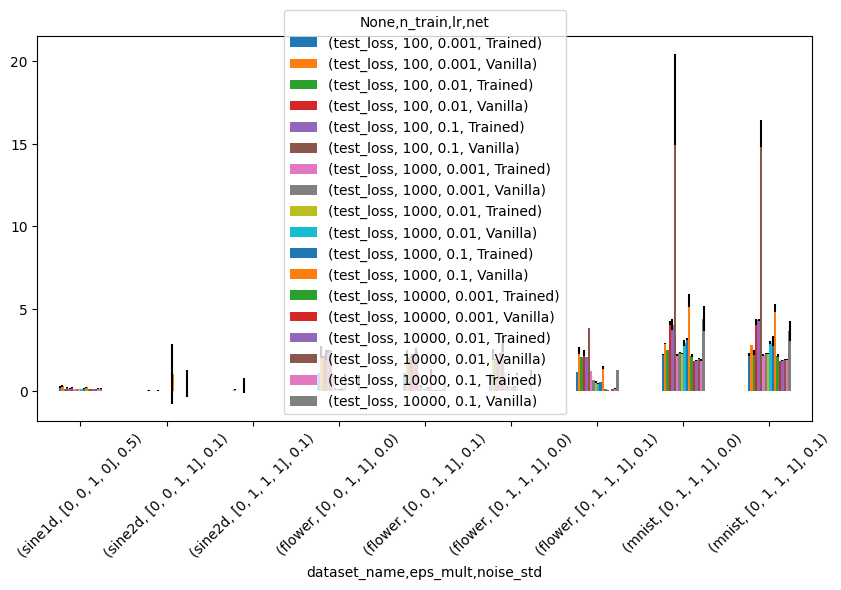

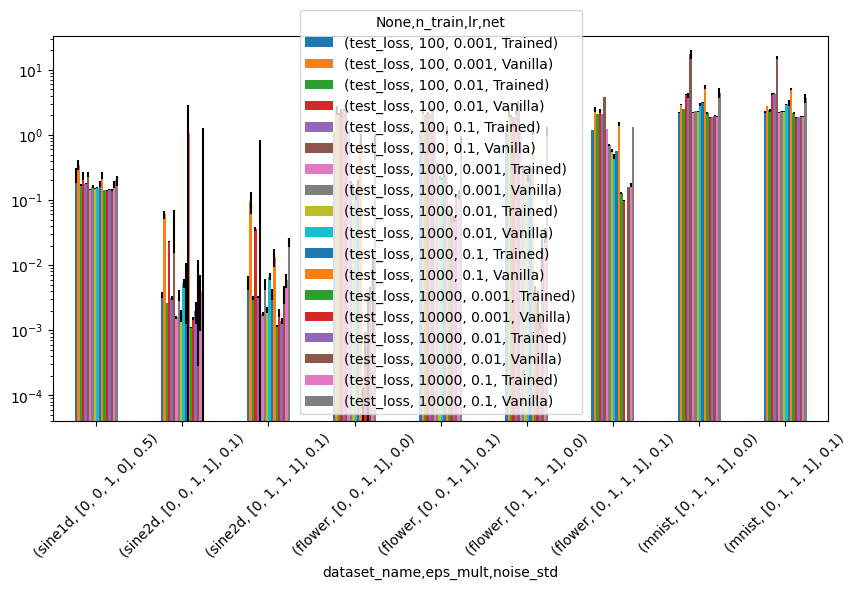

In [9]:
for logy in [False, True]:
    ddd_mean.plot(kind='bar', yerr = ddd_std, figsize = (10, 5), logy = logy, rot = 45)
    plt.show()

In [11]:
# n_plots = len(d_pivots)
# plot_dir = 'x'


# n_height, n_width = 1, n_plots if plot_dir == 'x' else n_plots, 1
# fig, axs = plt.subplots(n_plots, 1, figsize=(5*n_height, 2*n_width), tight_layout=True)

# for i, ((dataset_name, group), (d_pivot, map_kwargs)) in enumerate(d_pivots.items()):
#     ax = axs[i]

#     unstack = lambda d, metric: d.apply(metric).unstack().reset_index(level=0, drop = True)
#     d_mean, d_std = unstack(d_pivot, pd.Series.mean), unstack(d_pivot, pd.Series.std)

#     d_mean.plot(kind='barh', xerr=d_std, ax = ax, legend = False)
#     ax.set_title(f'{dataset_name} - {group}')
#     if i == 0: ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.5), ncol = 2)
    
#     if datasets_predict[dataset_name]['log']: ax.set_xscale('log')